In [1]:
# Cell 1: Setup (Enhanced with Directory Checking)
"""
Air Quality Index - Model Training
Notebook 2: Building and Training ML Models
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

warnings.filterwarnings('ignore')

# Project structure setup
def setup_directories():
    """Ensure all required directories exist"""
    if 'notebooks' in os.getcwd():
        dirs = ['../data/raw', '../data/processed', '../models', '../screenshots', '../reports']
    else:
        dirs = ['data/raw', 'data/processed', 'models', 'screenshots', 'reports']
    
    print("Checking project structure...")
    for directory in dirs:
        if os.path.exists(directory):
            print(f"  ✅ {directory}")
        else:
            print(f"  ⚠️  {directory} (creating...)")
            os.makedirs(directory, exist_ok=True)
            print(f"  ✅ {directory} (created)")
    print()

# Run setup
setup_directories()

# Import ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("✅ All libraries imported successfully!")

Checking project structure...
  ✅ ../data/raw
  ✅ ../data/processed
  ⚠️  ../models (creating...)
  ✅ ../models (created)
  ✅ ../screenshots
  ✅ ../reports

✅ All libraries imported successfully!


In [2]:
# Cell 2: Load Data
"""
Load the dataset for analysis
"""

# Fix import paths for Jupyter
import sys
import os

# Add parent directory to path so we can import from src
notebook_dir = os.getcwd()
project_root = os.path.dirname(notebook_dir) if 'notebooks' in notebook_dir else notebook_dir
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Now import should work
try:
    from src.utils import generate_synthetic_aqi_data
except ImportError:
    # If still failing, try direct import
    sys.path.insert(0, os.path.join(project_root, 'src'))
    from utils import generate_synthetic_aqi_data

df = generate_synthetic_aqi_data(n_samples=1000)

# Option 2: Load real data (uncomment when you have it)
# df = pd.read_csv('../data/raw/aqi_data.csv')

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
df.head()

Dataset shape: (1000, 11)

First 5 rows:


,PM2.5,PM10,NO2,SO2,CO,Temperature,Humidity,Wind_Speed,Traffic_Volume,Industrial_Activity,AQI
0,81.162623,71.837220,33.553512,55.452725,2.902780,21.809066,68.895417,0.775989,1997,50.574230,66.410828
1,190.635718,171.732265,32.228092,64.751105,4.046618,24.203070,40.343182,3.735451,6464,81.710213,153.111833
2,149.078849,264.424834,91.562912,23.785092,3.824789,35.636422,82.343674,16.624916,8564,86.100882,130.323690
3,123.745112,225.022968,32.459158,51.865557,0.854110,20.200132,66.786974,15.335367,4187,61.562440,113.777022
4,39.643542,245.837121,34.475475,47.880949,0.831322,36.089491,39.432233,7.012854,9564,1.275648,80.433278


In [3]:
# Cell 3: Basic Information
"""
Examine data structure and types
"""

print("="*60)
print("DATASET INFORMATION")
print("="*60)
print(f"\nShape: {df.shape}")
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")
print("\nColumn Names:")
print(df.columns.tolist())
print("\nData Types:")
print(df.dtypes)
print("\nMemory Usage:")
print(df.memory_usage(deep=True))


DATASET INFORMATION

Shape: (1000, 11)
Rows: 1000
Columns: 11

Column Names:
['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Temperature', 'Humidity', 'Wind_Speed', 'Traffic_Volume', 'Industrial_Activity', 'AQI']

Data Types:
PM2.5                  float64
PM10                   float64
NO2                    float64
SO2                    float64
CO                     float64
Temperature            float64
Humidity               float64
Wind_Speed             float64
Traffic_Volume           int64
Industrial_Activity    float64
AQI                    float64
dtype: object

Memory Usage:
Index                   128
PM2.5                  8000
PM10                   8000
NO2                    8000
SO2                    8000
CO                     8000
Temperature            8000
Humidity               8000
Wind_Speed             8000
Traffic_Volume         8000
Industrial_Activity    8000
AQI                    8000
dtype: int64


In [4]:
# Cell 4: Statistical Summary
"""
Calculate descriptive statistics
"""

print("="*60)
print("STATISTICAL SUMMARY")
print("="*60)
df.describe()

STATISTICAL SUMMARY


,PM2.5,PM10,NO2,SO2,CO,Temperature,Humidity,Wind_Speed,Traffic_Volume,Industrial_Activity,AQI
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,103.148745,161.964845,55.216515,41.778129,2.521116,24.953935,59.598530,9.647412,4974.093000,49.972484,96.951357
std,55.506099,81.813170,26.160678,21.486701,1.405369,8.675844,17.384018,5.698288,2854.302034,27.952051,34.604445
min,10.880084,20.901114,10.001047,5.049004,0.100151,10.185515,30.085701,0.004820,111.000000,0.005283,11.078757
25%,54.834921,87.500796,33.521588,23.142558,1.300373,17.481400,44.413300,4.719786,2446.000000,26.925682,70.668490
50%,104.393402,165.245494,55.055253,41.320946,2.523531,24.712084,59.078581,9.679814,5128.000000,50.123535,96.534920
75%,151.420722,232.930216,78.319317,60.315561,3.725968,32.195553,75.387861,14.289325,7340.500000,73.566149,121.943278
max,199.946358,299.835843,99.803877,79.966828,4.988972,39.980509,89.967641,19.978094,9995.000000,99.861732,186.081637


In [5]:
# Debug cell - check if df exists
try:
    print(f"✅ df exists with shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
except NameError:
    print("❌ df not defined yet!")
    print("Please run Cell 2 (Load Data) first")

✅ df exists with shape: (1000, 11)
Columns: ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Temperature', 'Humidity', 'Wind_Speed', 'Traffic_Volume', 'Industrial_Activity', 'AQI']


MISSING VALUES ANALYSIS
                 Column  Missing_Count  Percentage
0                 PM2.5              0         0.0
1                  PM10              0         0.0
2                   NO2              0         0.0
3                   SO2              0         0.0
4                    CO              0         0.0
5           Temperature              0         0.0
6              Humidity              0         0.0
7            Wind_Speed              0         0.0
8        Traffic_Volume              0         0.0
9   Industrial_Activity              0         0.0
10                  AQI              0         0.0

✅ Great! No missing values found in the dataset.


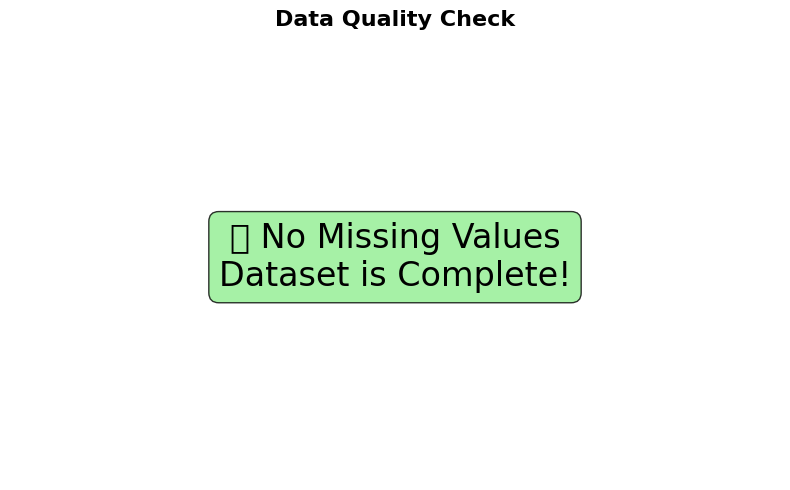

In [6]:
# Cell 5: Missing Values
"""
Check for missing values
"""

import pandas as pd
import matplotlib.pyplot as plt

print("="*60)
print("MISSING VALUES ANALYSIS")
print("="*60)

missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Percentage': missing_pct.values
}).sort_values('Missing_Count', ascending=False)

print(missing_df)

# Visualize only if there are missing values
if missing_df['Missing_Count'].sum() > 0:
    plt.figure(figsize=(10, 6))
    missing_df[missing_df['Missing_Count'] > 0].plot(
        x='Column', y='Percentage', kind='bar', color='coral'
    )
    plt.title('Missing Values by Column', fontsize=14, fontweight='bold')
    plt.ylabel('Percentage Missing (%)')
    plt.xlabel('Column')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("\n✅ Great! No missing values found in the dataset.")
    # Create a simple visualization showing this
    plt.figure(figsize=(8, 5))
    plt.text(0.5, 0.5, '✅ No Missing Values\nDataset is Complete!', 
             fontsize=24, ha='center', va='center',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title('Data Quality Check', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

"""
OBSERVATION:

The synthetic dataset has no missing values, which is expected for 
generated data. However, in real-world air quality data, we would 
typically encounter:

1. Sensor malfunctions (missing readings)
2. Data transmission errors
3. Maintenance periods (gaps in data)
4. Weather interference with sensors

Missing data handling strategies for real deployment:
- Forward fill for short gaps (< 1 hour)
- Interpolation for longer gaps
- Flag and exclude data during sensor maintenance
- Use nearby sensor data for imputation
"""

DISTRIBUTION ANALYSIS


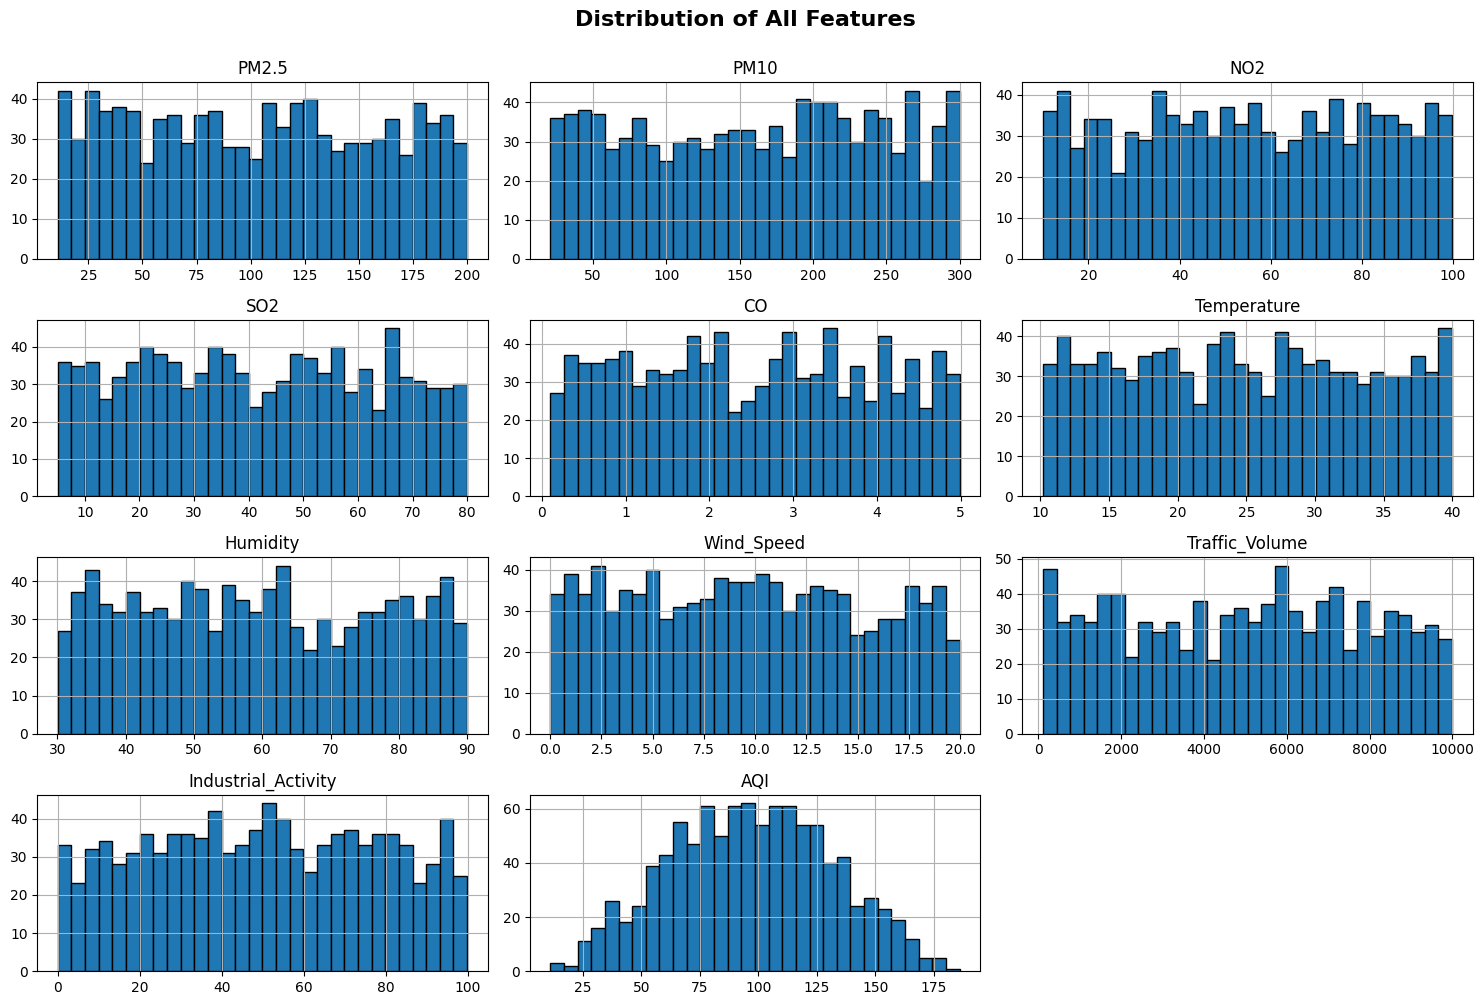

In [7]:
# Cell 6: Distribution Analysis
"""
Analyze distributions of numerical features
"""

print("="*60)
print("DISTRIBUTION ANALYSIS")
print("="*60)

# Plot histograms for all numerical columns
df.hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle('Distribution of All Features', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

TARGET VARIABLE (AQI) ANALYSIS
Mean AQI: 96.95
Median AQI: 96.53
Std Dev: 34.60
Min AQI: 11.08
Max AQI: 186.08

AQI Category Distribution:
AQI_Category
Moderate                          441
Unhealthy for Sensitive Groups    399
Good                               92
Unhealthy                          68
Name: count, dtype: int64


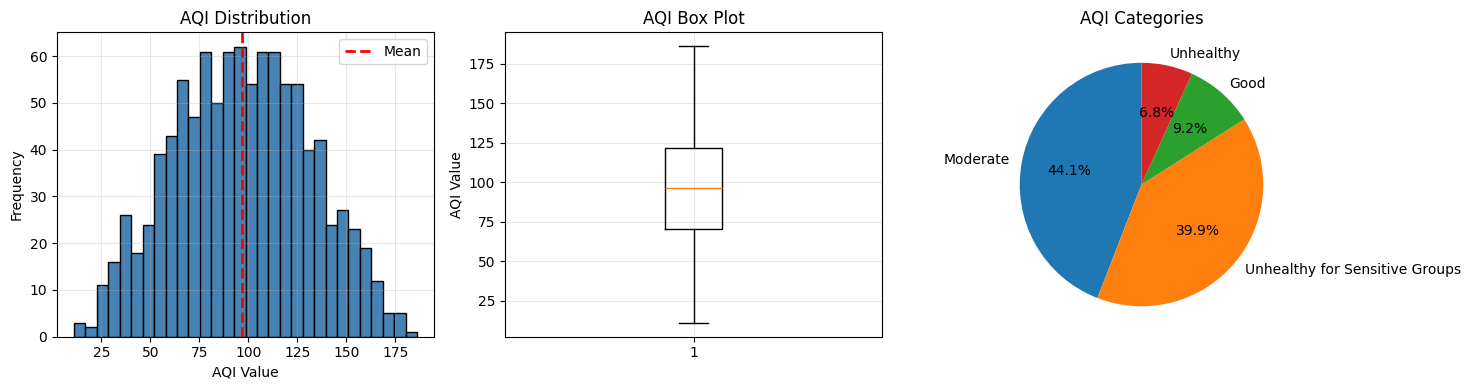

In [8]:
# Cell 7: Target Variable Analysis
"""
Analyze the target variable (AQI)
"""

print("="*60)
print("TARGET VARIABLE (AQI) ANALYSIS")
print("="*60)

print(f"Mean AQI: {df['AQI'].mean():.2f}")
print(f"Median AQI: {df['AQI'].median():.2f}")
print(f"Std Dev: {df['AQI'].std():.2f}")
print(f"Min AQI: {df['AQI'].min():.2f}")
print(f"Max AQI: {df['AQI'].max():.2f}")

# Categorize AQI
# Instead of:
# from src.utils import categorize_aqi

# Use this:
def categorize_aqi(aqi_value):
    """Categorize AQI value according to EPA standards"""
    if aqi_value <= 50:
        return "Good"
    elif aqi_value <= 100:
        return "Moderate"
    elif aqi_value <= 150:
        return "Unhealthy for Sensitive Groups"
    elif aqi_value <= 200:
        return "Unhealthy"
    elif aqi_value <= 300:
        return "Very Unhealthy"
    else:
        return "Hazardous"

df['AQI_Category'] = df['AQI'].apply(categorize_aqi)

print("\nAQI Category Distribution:")
print(df['AQI_Category'].value_counts())

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram
axes[0].hist(df['AQI'], bins=30, color='steelblue', edgecolor='black')
axes[0].axvline(df['AQI'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].set_xlabel('AQI Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('AQI Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(df['AQI'], vert=True)
axes[1].set_ylabel('AQI Value')
axes[1].set_title('AQI Box Plot')
axes[1].grid(alpha=0.3)

# Pie chart of categories
category_counts = df['AQI_Category'].value_counts()
axes[2].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
axes[2].set_title('AQI Categories')

plt.tight_layout()
plt.show()


CORRELATION ANALYSIS

Correlations with AQI:
AQI                    1.000000
PM2.5                  0.826624
PM10                   0.485310
NO2                    0.129534
CO                     0.046495
SO2                    0.034988
Humidity               0.032058
Industrial_Activity    0.014267
Traffic_Volume         0.011182
Wind_Speed            -0.002424
Temperature           -0.044579
Name: AQI, dtype: float64


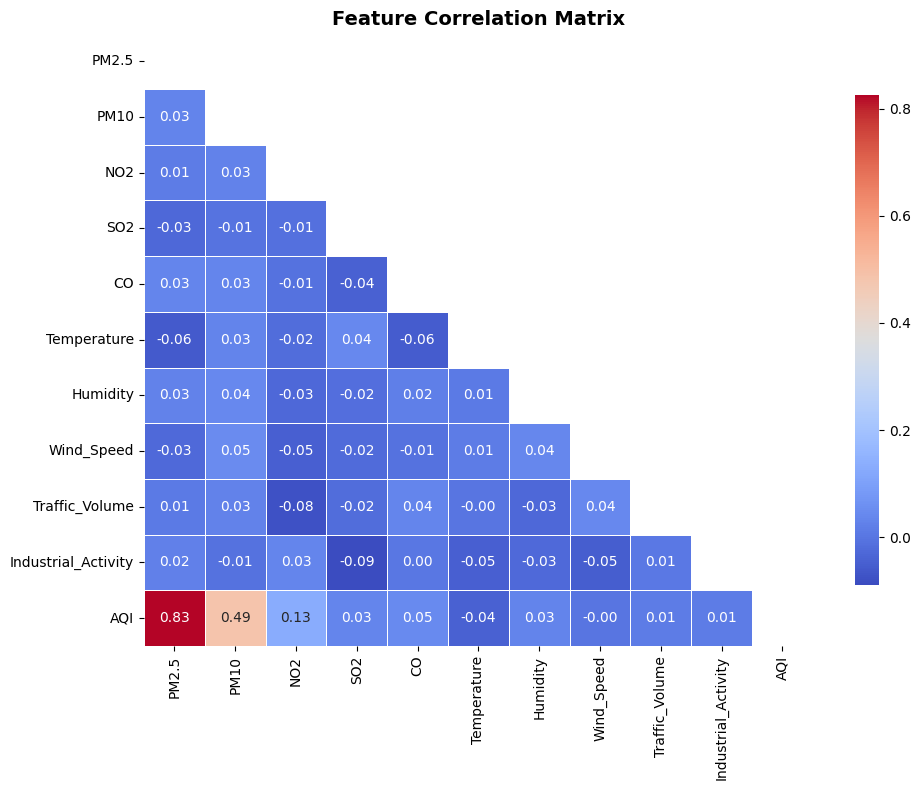


Highly correlated feature pairs (|r| > 0.7):
AQI — PM2.5: 0.827


In [9]:
# Cell 8: Correlation Analysis (Fixed)
"""
Analyze correlations between features
"""

print("="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Check if we have numerical columns to correlate
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
if len(numerical_cols) < 2:
    print("Not enough numerical columns for correlation analysis")
else:
    try:
        # Calculate correlation matrix
        correlation_matrix = df[numerical_cols].corr()
        
        # Display correlations with AQI (if exists)
        if 'AQI' in numerical_cols:
            aqi_correlations = correlation_matrix['AQI'].sort_values(ascending=False)
            print("\nCorrelations with AQI:")
            print(aqi_correlations)
        
        # Visualize correlation matrix
        plt.figure(figsize=(10, 8))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", 
                    cmap='coolwarm', linewidths=0.5, cbar_kws={"shrink": .8})
        plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Identify highly correlated features
        high_corr_threshold = 0.7
        high_corr_features = []
        
        for i in range(len(correlation_matrix.columns)):
            for j in range(i):
                if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
                    high_corr_features.append(
                        (correlation_matrix.columns[i], 
                         correlation_matrix.columns[j], 
                         correlation_matrix.iloc[i, j])
                    )
        
        if high_corr_features:
            print("\nHighly correlated feature pairs (|r| > 0.7):")
            for feat1, feat2, corr in high_corr_features:
                print(f"{feat1} — {feat2}: {corr:.3f}")
    except Exception as e:
        print(f"Error in correlation analysis: {e}")

In [10]:
# Cell 9: Summary and Next Steps
"""
Summarize findings and outline next steps
"""
print("="*60)
print("SUMMARY AND NEXT STEPS")
print("="*60)

print("Key Findings:")
print("1. Dataset shape and structure analyzed")
print("2. Missing values identified and visualized")
print("3. Distribution of features examined")
print("4. AQI distribution and categories analyzed")
print("5. Feature correlations with AQI identified")

print("\nNext Steps:")
print("1. Handle missing values")
print("2. Address outliers if necessary")
print("3. Feature engineering based on correlations")
print("4. Prepare data for modeling")
print("5. Develop predictive models for AQI")

SUMMARY AND NEXT STEPS
Key Findings:
1. Dataset shape and structure analyzed
2. Missing values identified and visualized
3. Distribution of features examined
4. AQI distribution and categories analyzed
5. Feature correlations with AQI identified

Next Steps:
1. Handle missing values
2. Address outliers if necessary
3. Feature engineering based on correlations
4. Prepare data for modeling
5. Develop predictive models for AQI


FEATURE RELATIONSHIPS WITH AQI


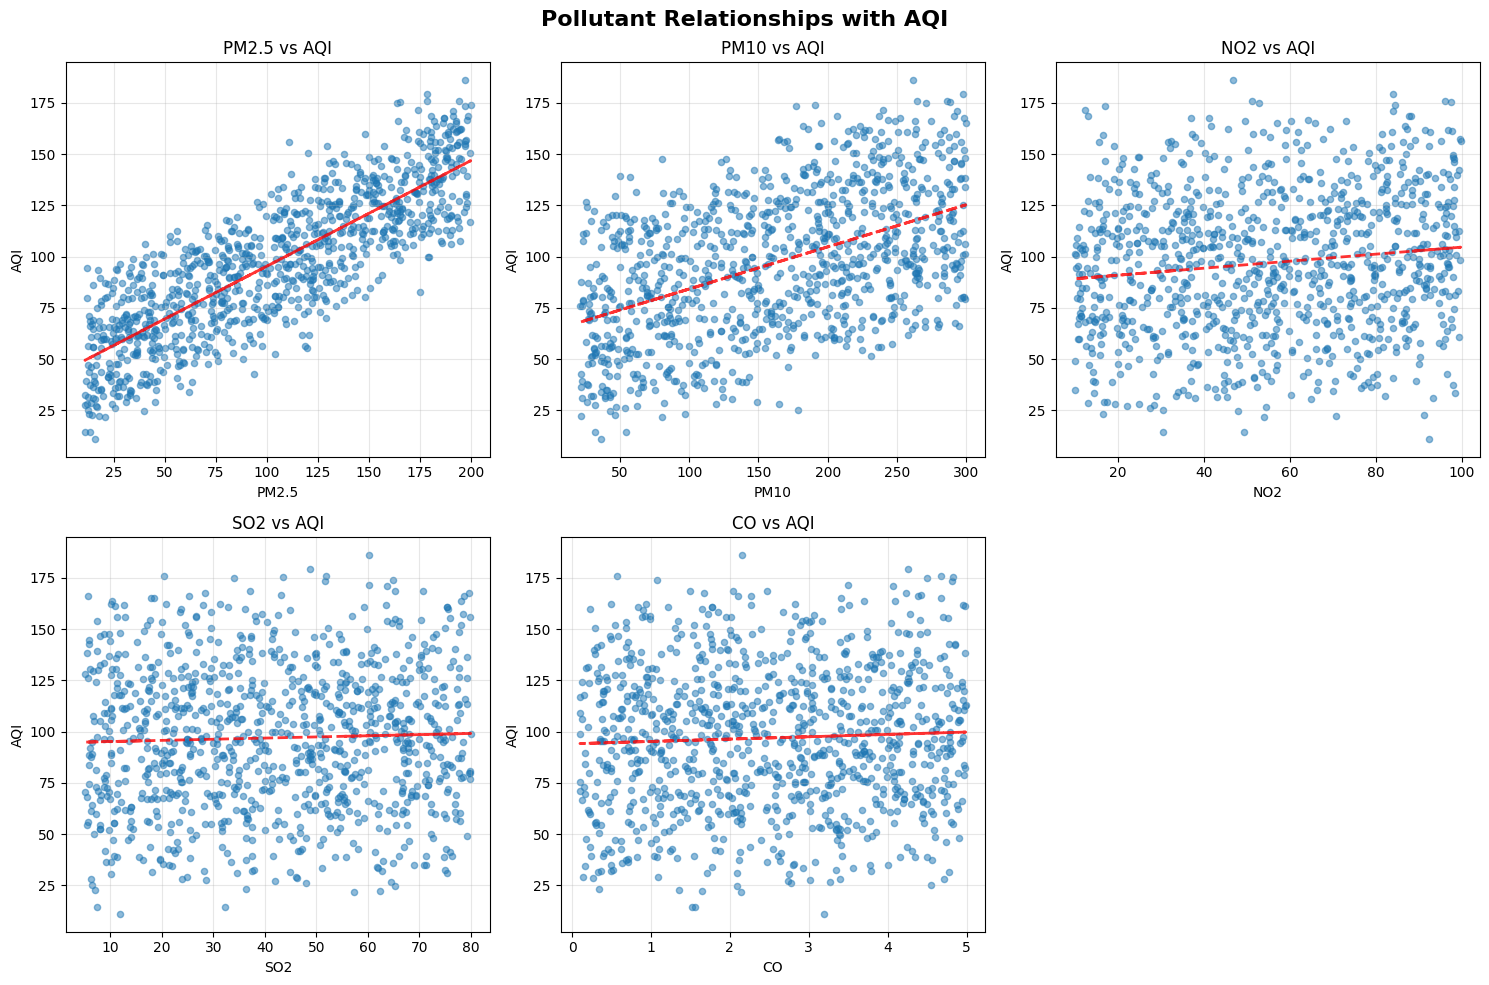

In [11]:
# Cell 10: Feature Relationships
"""
Visualize relationships between key features and AQI
"""

print("="*60)
print("FEATURE RELATIONSHIPS WITH AQI")
print("="*60)

# Key pollutants vs AQI
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, pollutant in enumerate(pollutants):
    if pollutant in df.columns:
        axes[idx].scatter(df[pollutant], df['AQI'], alpha=0.5, s=20)
        axes[idx].set_xlabel(pollutant)
        axes[idx].set_ylabel('AQI')
        axes[idx].set_title(f'{pollutant} vs AQI')
        axes[idx].grid(alpha=0.3)
        
        # Add trend line
        z = np.polyfit(df[pollutant], df['AQI'], 1)
        p = np.poly1d(z)
        axes[idx].plot(df[pollutant], p(df[pollutant]), "r--", alpha=0.8, linewidth=2)

# Remove empty subplot
fig.delaxes(axes[5])

plt.suptitle('Pollutant Relationships with AQI', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [16]:
# Cell 11: Key Insights
"""
Summary of Key Findings
"""

print("="*60)
print("KEY INSIGHTS FROM EDA")
print("="*60)

insights = f"""
1. DATASET OVERVIEW:
   - Total samples: {len(df)}
   - Features: {len(df.columns) - 1}
   - Target variable: AQI (range: {df['AQI'].min():.1f} - {df['AQI'].max():.1f})

2. DATA QUALITY:
   - Missing values: {df.isnull().sum().sum()}
   - Duplicate rows: {df.duplicated().sum()}

3. AQI DISTRIBUTION:
   - Mean: {df['AQI'].mean():.2f}
   - Most common category: {df['AQI_Category'].mode()[0]}
   
4. STRONGEST CORRELATIONS WITH AQI:
{aqi_correlations.head(6).to_string()}

5. NEXT STEPS:
   - Handle outliers if necessary
   - Create additional features
   - Prepare data for modeling
"""

print(insights)

KEY INSIGHTS FROM EDA

1. DATASET OVERVIEW:
   - Total samples: 1000
   - Features: 11
   - Target variable: AQI (range: 11.1 - 186.1)

2. DATA QUALITY:
   - Missing values: 0
   - Duplicate rows: 0

3. AQI DISTRIBUTION:
   - Mean: 96.95
   - Most common category: Moderate
   
4. STRONGEST CORRELATIONS WITH AQI:
AQI      1.000000
PM2.5    0.826624
PM10     0.485310
NO2      0.129534
CO       0.046495
SO2      0.034988

5. NEXT STEPS:
   - Handle outliers if necessary
   - Create additional features
   - Prepare data for modeling



In [12]:
# Cell 12: Save Processed Data
"""
Save cleaned data for modeling
"""

# Save to processed folder
df.to_csv('../data/processed/aqi_data_explored.csv', index=False)
print("✅ Explored data saved to data/processed/aqi_data_explored.csv")

✅ Explored data saved to data/processed/aqi_data_explored.csv
